In this article, I will try to investigate the following question,
> Looking at socio-economic status, gender, and age, who's and who's not survive the Titanic?

Below is the description of titanic data, from the original link, [Kaggle](https://www.kaggle.com/c/titanic/data).

```
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.
```

Next I will import the related libraries to perform the analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('darkgrid')
import numpy as np
import scipy.stats as sp

In [2]:
df = pd.read_csv('dataset/titanic_data.csv')

In [3]:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
4                           Allen, Mr. William Henry    male   35      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

Let's see the number of rows in this dataset

In [7]:
df.shape

(891, 12)

And the number of person,

In [8]:
df.Name.nunique()

891

Okay, so we know that each person represent one observation in this dataset. Let's see the distribution of age in this dataset.

In [9]:
df.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

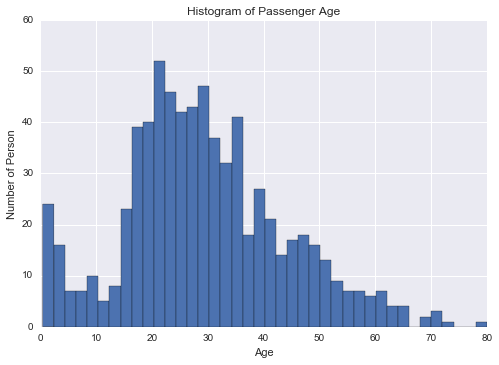

In [10]:
df.Age.hist(bins=40)
plt.xlabel("Age")
plt.ylabel("Number of Person")
plt.title("Histogram of Passenger Age");

I choose histogram since I only analyze one numerical variable. I choose 40 as nunmber of bins to let the histogram show smooth distribution of the data. And since we see from the statistics that the age is max at 80 years old, every 20 year will have the exact edge of the histogram.

I can see from this histogram that many children is below 5 years old. Some of them are babies which we see that there's a peak around 1 year. This histogram will have an almost normal distribution if there isn't a peak around 1 year old. The earlier statistics show that median is 28 year old, and mean is 29 year old. You can also tell that the distribution is normal when you have similar median and mean.

Overall the plot tells us that the passengers' age is distributed around mid-end 20's. Let's see if the distribution of the age is actually different between whether or not the passengers have survived.


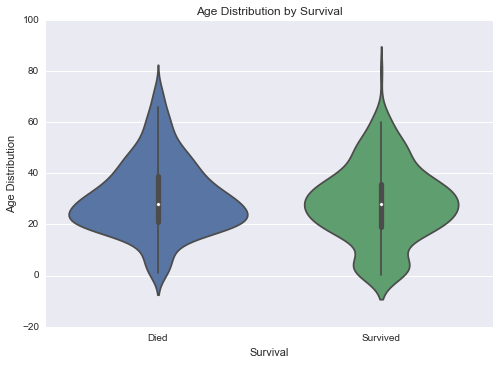

In [15]:
p = sns.violinplot(data = df, x = 'Survived', y = 'Age')
p.set(title = 'Age Distribution by Survival', 
        xlabel = 'Survival', 
        ylabel = 'Age Distribution', 
        xticklabels = ['Died', 'Survived']);

Now this is interesting. We can see that from violin plot, the distribution is a little bit different. I use violin plot because I can see the distribution of `Age` by `Survived` side by side.

The distribution of the age shows bimodal distribution of people who survived. Many old people died from the tragedy, though we see 1 80 year-old man did survive the tragedy. We can see the person below.

In [18]:
df[(df.Survived == 1) & (df.Age == 80)]

PassengerId  Survived  Pclass                                  Name  \
630          631         1       1  Barkworth, Mr. Algernon Henry Wilson   

      Sex  Age  SibSp  Parch Ticket  Fare Cabin Embarked  WomenChildren  
630  male   80      0      0  27042    30   A23        S              0

To support the plot, I also include relevant statistics between Age and Survived.

In [24]:
df.groupby('Survived').Age.describe().unstack(level=0)

Survived           0           1
count     424.000000  290.000000
mean       30.626179   28.343690
std        14.172110   14.950952
min         1.000000    0.420000
25%        21.000000   19.000000
50%        28.000000   28.000000
75%        39.000000   36.000000
max        74.000000   80.000000

If we see from the statistics everything is similar. Children who died minimum is 1 years old, while babies who survive minimum at 5 months old. Again if I observe the plot, many children survived the accident, at least compared to the children who didn't.

If you remember from *Titanic* movies, children and women are prioritized to get to the lifeboat. It's interesting to know whether this is actually true.

*Is women and children survival rate is higher than those who didn't?*

To get into this, I create a frequency table. Children are described as passenger below 12 years old. And gender already described by `Sex` column.

In [78]:
df['WomenChildren'] = np.where((df.Age <= 12) | (df.Sex == 'female'),1,0)

I'm using ChiSquare from Scipy library. This function has takes frequency table that I've created earlier, and then output chisquare statistic, p-value, degree of freedom, and the expected frequency table if both variables aren't related. Since for `Survived` is categorical and some of the variables also categorical, I create neat function that calculate frequency table and compute ChiSquare Indepence test for 2 Pandas categorical Series.

In [85]:
def compute_freq_chi2(x,y):
    """This function will compute frequency table of x an y
    Pandas Series, and use the table to feed for the contigency table
    
    Parameters:
    -------
    x,y : Pandas Series, must be same shape for frequency table
    
    Return:
    -------
    None. But prints out frequency table, chi2 test statistic, and 
    p-value
    """
    freqtab = pd.crosstab(x,y)
    print("Frequency table")
    print("============================")
    print(freqtab)
    print("============================")
    chi2,pval,dof,expected = sp.chi2_contingency(freqtab)
    print("ChiSquare test statistic: ",chi2)
    print("p-value: ",pval)
    return

In [86]:
compute_freq_chi2(df.Survived,df.WomenChildren)

Frequency table
WomenChildren    0    1
Survived               
0              452   97
1               88  254
ChiSquare test statistic:  280.393048965
p-value:  6.16515742548e-63


From the frequency table, we can see a magnitude difference of women and children that survived compared to those who didn't. Women and children survived is about 2.5 times higher than women and children whom not survived. On the contrary, adult men is about 5 times higher between not survived and survived. To be fair, let's put this to a statistical test.


Since both independent and dependent variable are categorical, I choose Chi-Square Independece test. For this test to be true, Let's validate the condition,

* Each cell has at least 5 expected cases. **Checked**.
* Each case only contributes to once cell in the table. **Checked**.
* If sample, random sample and less than 10% population. **This dataset is already a population**.

Since we have checked all the condition, we can proceed to the test. And as expected, chi-square statistic provide very high number, and p value which practically zero. Thus the data provide convincing evidence that whether the passenger woman or children and whether they survived are related. Just for the sake of curiosity, how is the accuracy if we take it as predictive model?

In [28]:
(df['WomenChildren']  == df.Survived).mean()

0.79236812570145898

There you go, I got 79.24% accuracy.

Titanic was a massive ship. Again remembering the movie back then, rich and poor people get to the ship. I wonder how Titanic data required social economy status of passenger, which represented by `Pclass`. We could see if the fare vary across this variable.

In [29]:
df.groupby('Pclass').Fare.mean()

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

From this result, we see that there's huge price jump between upper class and middle/lower class! Although it's no surprise. I recall from the movie, upper class room is family room, and facilitated with a lot of fancy stuff. While in lower class (DiCaprio's room), people have to shared between other passengers.

Perhaps number alone won't satisfy you enough. Let's take it to the visualization. And since in this analysis, we want to know people who survive, I also throw whether the people `survive` into the equation.

I will plot the visualization using bar plot, since I want to see different of Fare across social-economic status. And I want to differentiate the status by `Survive` to see if it depends on these two variables.

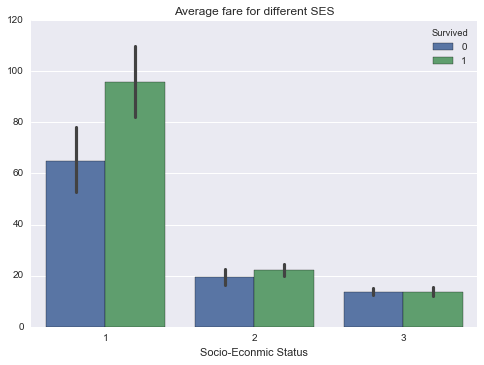

In [30]:
sns.barplot(x="Pclass",y="Fare",hue="Survived",data=df,estimator=np.mean)
plt.ylabel("")
plt.xlabel("Socio-Econmic Status")
plt.title("Average fare for different SES");

Looking at this plot, I see something expected and unexpected. First the expected one, I see the average of fare of middle/lower is similar but the difference is huge when compared to the upper class. This is again, expected since earlier we have saw the number.

The unexpected one, is whether survive vary in the upper class! Lower/middle class has similar fare, but there is a clear difference of average fare of in the upper class which result in life and death difference. What's the cause of this? They pay same upper class. What makes the different price in one class? What I can think of is because they have different cabin. Is it because lifeboats are placed in particular cabin? Unfortunately it's hard to know which cabin is better than others, except with Fare. 

In [31]:
(df[(df.Pclass == 1)]
 .groupby([df.Cabin.str[:1],'Survived'])
 .Fare
 .mean()
 .unstack())

Survived          0           1
Cabin                          
A         35.496350   44.341071
B         57.137500  132.832026
C         99.972396  100.274046
D         59.613086   64.505123
E         48.460714   58.571067
T         35.500000         NaN

We see from the table above, Cabin with prefix B is the most expensive one compared to ohers. Cabin C is probably the most expensive on average.  But will this guarantee for whether the passengers survive?

In [32]:
(df[(df.Pclass == 1)]
 .groupby([df.Cabin.str[:1],'Survived'])
 .PassengerId
 .count()
 .unstack())

Survived   0   1
Cabin           
A          8   7
B         12  35
C         24  35
D          7  22
E          7  18
T          1 NaN

Again, the cabin doesn't guarantee whether the passengers are save. Cabin B has 3 times ratio but so other cabins. Cabin C not even a magnitude higher. So there's some limitations that we have. 

At least whether the passenger is in the upper class can be one of the factor of whether the passengers is survived. Let's test those. Again I will build frequency table of SES vs whether passengers is survived, and perform Chi-Square Independence test to confirm. 

In [101]:
compute_freq_chi2(df.Survived,df.Pclass)

Frequency table
Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
ChiSquare test statistic:  102.888988757
p-value:  4.5492517113e-23


Since we already validated our dataset earlier (also from the frequency table, we can see that each cell has at least 5 expected cases), we can directly perform the statistical test.

So indeed, the test statistic result really high and again p-value is practically zero. The data provide convincing evidence that economic status and whether they survived are related.

Lastly, we have `Embarked` variable. Let's see the survivability rate for each embarkation point.

In [4]:
df.groupby('Embarked').Survived.mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

Okay, we see that (C)herbourg has huge survivability rate compared to other two! How is this possible? My first thought would be Cherbourg could be the first/last embarkation point. So they will put around the corner of the ship. When googling schedule of embarkation, I found this [link](http://www.discoverireland.ie/Places-To-Go/Cork/Features/Remembering-RMS-Titanic) that stated the embarkation is in this order, 

`(S)outhampton - (C)herbourg - (Q)ueenstown`

Cherbourg is actually in the middle embarkation point. So my assumption is false. Nonetheless, let's see frequency table and test statistics.

In [102]:
compute_freq_chi2(df.Survived,df.Pclass)

Frequency table
Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
ChiSquare test statistic:  102.888988757
p-value:  4.5492517113e-23


Again the dataset has been validated for statistical test. The other thing is to observe the expected cases of each cell is 5, from the frequency table we know that to be true. Using ChiSquare Indepence test, our p-value is also practically zero. Thus the data also provide convincing evidence that Embarkation Point and survivability are related.

Let's see if embarkation point play nice with other predictors, age for example. I use `describe` method to describe age by Embarkation point.

In [100]:
df.groupby('Embarked').Age.describe().unstack(level=0)

Embarked           C          Q           S
count     130.000000  28.000000  554.000000
mean       30.814769  28.089286   29.445397
std        15.434860  16.915396   14.143192
min         0.420000   2.000000    0.670000
25%        21.250000  17.500000   21.000000
50%        29.000000  27.000000   28.000000
75%        40.000000  34.500000   38.000000
max        71.000000  70.500000   80.000000

Looking at this statistics, I know that all of the embarkation point has pretty normal distribution since the median and mean are similar. Let's use the violin plot again to confirm this and comparing age distribution by embarkation point side by side.

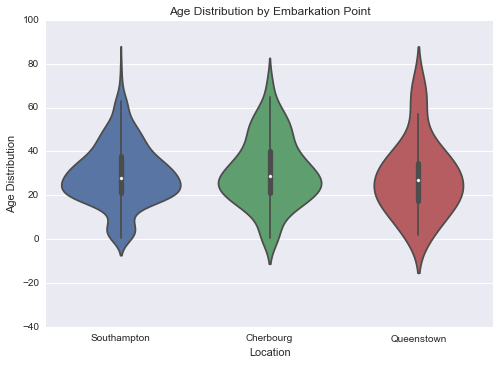

In [97]:
p = sns.violinplot(data = df, x = 'Embarked', y = 'Age',order=["S","C","Q"])
p.set(title = 'Age Distribution by Embarkation Point', 
        xlabel = 'Location', 
        ylabel = 'Age Distribution',
        xticklabels = ['Southampton','Cherbourg', 'Queenstown']);

I can see from the violin plot little different age distribution betwen each location. Queenstown has wider distribution among the other two. Cherbourg in the middle, and Southampton has thinner distribution and highest peak. This wide distribution can also be explained by standard deviation in the earlier statistics. 

We can see a little peak in Southampton's age distribution, in children range. Children is supposed to be important factor when determining survivability. We can see that Southampton has higher peak children age distribution compared to Cherbourg. Nothing odd about Cherbourg in age distribution, explained by relevant statistic and violin plot. This suggest that oddness of Cherbourg can't be explained by age.

So again based on observation of the data what I found is many passengers who survived is based on:

* Passengers are women or children.
* Passengers are an upper class.
* Passengers are from Cherbourg.

Testing the accuracy if we want to built predictive modelling:

In [35]:
((df['WomenChildren'] == df['Survived']) | # Whether passengers is women or babies
 ((df.Pclass == 1) == df['Survived']) |
 ((df.Embarked == "C") == df['Survived'])).mean() # or they are an upper class SES.

0.95735129068462399

Okay, so I achieved 95.74% accuracy by statistic modelling. There's some limitation in my analysis is determining what caused difference in survived in upper classs. Checking whether the cabin has something to do about it has failed.

Note that what I really do is observation based on this data. Hence this is **correlation** and not causation. You will have a causation when you have a controlled experiment. One must rebuild titanic condition, how it wrecked, and makes a total near-to-death experience. I don't really think your participants want to experiment that.  

There are some other variables that I don't analyze, like whether the passengers have siblings or partners. **These variables are bias in the dataset**. If you see the explanation, the description of the data at the top of this article, it stated:

*With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored. *

So this bias can lure us into thinking that not having family relations will somehow affect whether or not the passengers are going to survived, based on the observation of the data. Because of this data limitation, these variables are dangerous and best to not analyze if concerning about survivability.

The other concern is about how I handle missing values. I will build a frequency table to count whether or not the value is missing for each column.

In [36]:
df.apply(lambda x: x.isnull().value_counts())

PassengerId  Survived  Pclass  Name  Sex  Age  SibSp  Parch  Ticket  \
False          891       891     891   891  891  714    891    891     891   
True           NaN       NaN     NaN   NaN  NaN  177    NaN    NaN     NaN   

       Fare  Cabin  Embarked  WomenChildren  
False   891    204       889            891  
True    NaN    687         2            NaN

By looking at the data, the survivability of passengers variable doesn't have any missing value. This is a good thing since this is our main interest. 

The highest value of missing data is `Cabin`. One way to handle it is find other passenger (if they have family who's also onboard) with same family name, and apply same Cabin with them. Intuitively, if their cabin are different, it may still in adjacent of each other. But as you can see from the analysis, cabin is not an important factor to determine whether the passengers have survived. So I won't dig deeper as to handle the missing value.

The second highest is `Age`. This variable did concern me since this is one of the feature in my statistical modelling. I don't handle missing the value, instead I just ignored them. The reason is the range of age is too broad. I can create imputation for example, for baseball player which ["the majority of players can be found in the 27-31 age range."](http://bleacherreport.com/articles/367083-age-to-reason-the-mlb-players-average-age). But Titanic passengers are from all age. It's too error prone to impute age of Titanic passengers. I won't get too worried about that since our data size is still large enough to do statistical test. By default pandas will ignore the missing value when I perform most operations.

Lastly, I'm not concern about impute `Embarked` variable since it's only small value and our data is still large enough.

Future work can be done. For example explore more about the cabin and use ticket number to pinpoin the location of passengers. Since the tragedy occurred in the middle of the night (again, movie-based-assumption), they should be near their cabin. And also investigating of why passengers embarked from Cherbourg has higher survivability rate compared to Southampton or Queenstown. This oddness looks pretty normal and undetected in the analysis.